# Using regression to predict house prices in Ames, Iowa
## Exploratory Analysis
Firstly importing all required packages and modules as well as setting some base plot style settings.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import linear_model

In [2]:
plt.rcParams['figure.figsize'] = (21.0, 13.0)
plt.rcParams['font.size'] = 18.0
sns.set_style('whitegrid')
sns.set_palette('pastel')

Then we can import the full house price data that we intend to train and test our regression model on as found in [train.csv](https://github.com/HStuklis/my-projects/tree/master/house-prices/train.csv).

In [3]:
df_full = pd.read_csv('./train.csv')

For a full description of the data and labelling of the data entries we can refer to [data_description.txt](https://github.com/HStuklis/my-projects/tree/master/house-prices/data_description). We can observe the number of entries and predictors by the following.

In [4]:
df_full.shape

(1460, 81)

So we are given 1460 data entries with 81 recorded variables for each. In our project statement we are given that we need to seperate the data provided in train.csv into 70% training data and 30% testing data. So we can find how many of the original 1460 data entries we first need to select as the testing data by approximately finding 70% of 1460.

In [5]:
np.ceil(1460*0.7)

1022.0

Hence, we can select our training data by slicing.

In [6]:
df_train = df_full[:1022]
df_train.tail()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1017,1018,120,RL,NaN,5814,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2009,COD,Abnorml,187500
1018,1019,80,RL,NaN,10784,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,160000
1019,1020,120,RL,43.0,3013,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2006,WD,Normal,213490
1020,1021,20,RL,60.0,7024,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,176000
1021,1022,20,RL,64.0,7406,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,New,Partial,194000


Which gives our testing data to be the rest of the left over data in df_full.

In [7]:
df_test = df_full[1022:-1]
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1022,1023,50,RM,52.0,9439,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2007,WD,Normal,87000
1023,1024,120,RL,43.0,3182,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,WD,Normal,191000
1024,1025,20,RL,NaN,15498,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2008,COD,Abnorml,287000
1025,1026,20,RL,70.0,7700,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,3,2007,WD,Normal,112500
1026,1027,20,RL,73.0,9300,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,167500


Now we can consider finding the predictor variable label of house selling price by overviewing all of the column variable labels.

In [8]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

So we find that we are trying to predict $\texttt{SalePrice}$ base on the other 80 variables present in the data. We can look at some summary and basic statistics for the sale price to get a feeling for the overall house prices.

In [9]:
round(df_train.SalePrice.describe(), 3)

count      1022.000
mean     181713.254
std       79854.663
min       34900.000
25%      130000.000
50%      163745.000
75%      214975.000
max      755000.000
Name: SalePrice, dtype: float64

We can see a very high spread of house prices ranging from a quite low value of 35k USD to 755k USD. The mean house price is around 181k USD and there is a good deal of variability present with a standard deiviation from this mean of 80k USD. We can also view this in histogram format to show how much of the data is massed around the mean.

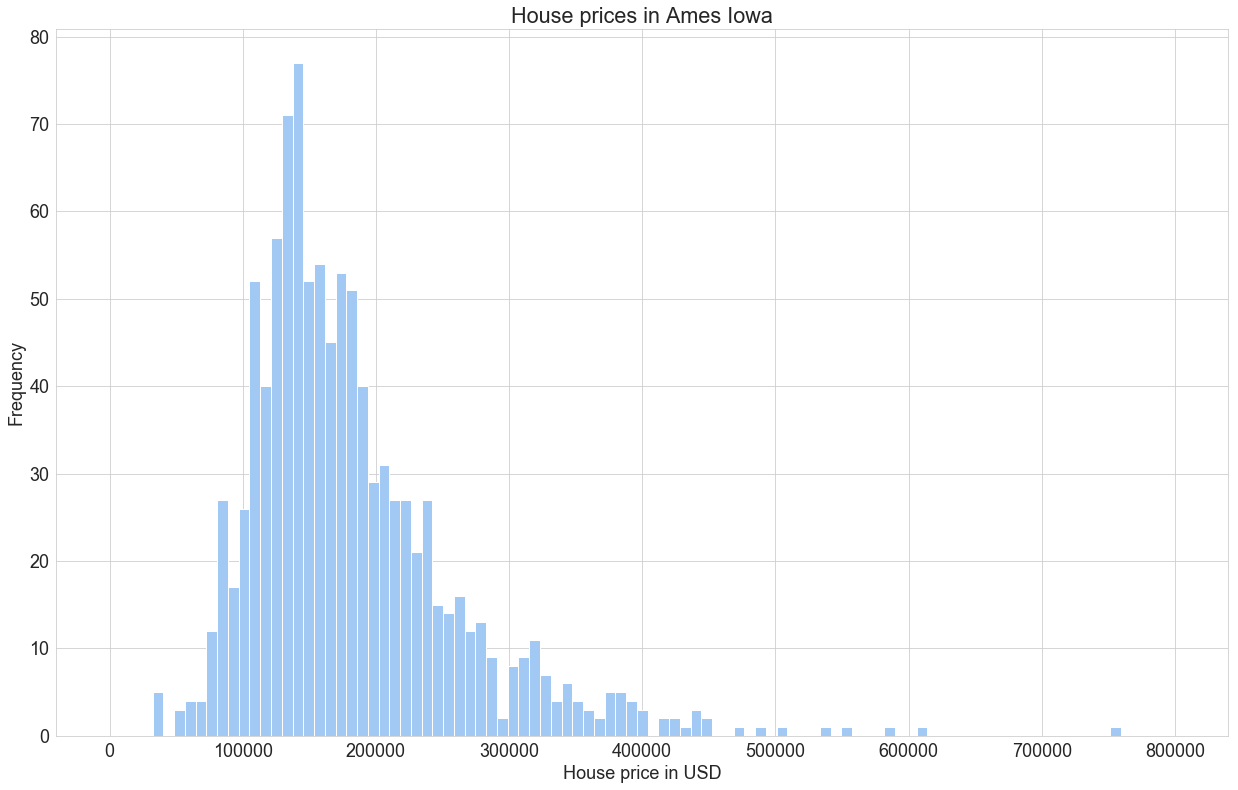

In [10]:
plt.hist(df_train.SalePrice, bins = np.linspace(0, 800000, 100))
plt.xlabel('House price in USD')
plt.ylabel('Frequency')
plt.title('House prices in Ames Iowa');

So we can see a roughly positively placed normal distribution about the mean. Where it is impossible to drop below a certain price around 35k USD. We can see a large right tail from the bell shaped mass where we expect the larger or more up-market house prices to be placed. So a robust regression model of this data should be able to distuinguish what features place the houses in the far right tail.

We can also check if all gathered variables have the same number of counts, as in each variable has a recorded value for each house in the data. This is to ensure that our entire data set is coherent and that there were no major errors in the data collection. To do so we can find the maximum count and then check for variables that do not meet this maximum count. 

In [12]:
sum(df_train.count() != 1022)

18

So we find that there are 19 variables present in the data that do not have complete entries for each listed house. In other terms, we know that there are some incomplete entries present in the data set. This could also mean that there are some varables which use the Python reserved 'NA' variable value. If a data point has this listed value in a categorical variable then it will not contribute to the count. If we want to train a robust model on this data set then we need to determine whether these incomplete variables should be used. 